In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
import tensorflow.keras as ks
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import backend as Ks
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from numpy.random import seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib as mpl
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
def getCNNModeltoInterpret(fname):
    learning_rate = 0.1
    momentum = 0.0
    model = ks.Sequential()
    # Conv Layer 1
    model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(None,3),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Conv Layer 2-11 (10 layers)
    for layernum in range(10):
        model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
    # Conv Layer 12
    model.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('sigmoid'))
    previousModel = ks.models.load_model(fname)
    model.set_weights(previousModel.get_weights())
    return model

In [3]:
def getLSTMModeltoInterpret(fname):
    previousModel = ks.models.load_model(fname)
    model = Sequential()
    model.add(LSTM(100, input_shape=(None, 3),return_sequences=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.set_weights(previousModel.get_weights())
    return model

In [4]:
def getCNNSegMap(model, dfstat, data):
    TOTAL_LEN = np.shape(data)[0]

    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]

    rrnaf = (data['RRraw'].values - mRR)/sdRR
    spo2naf = (data['SpO2raw'].values - mSpO2)/sdSpO2
    hrnaf = (data['HRraw'].values - mHR)/sdHR
    
    X_TEST = np.zeros((1,TOTAL_LEN,3), dtype=np.float32)
    X_TEST[0,:,0] = rrnaf
    X_TEST[0,:,1] = spo2naf
    X_TEST[0,:,2] = hrnaf
    predictions = model.predict(X_TEST)
    return predictions[0,:,0]

In [5]:
def getLSTMSegMap(model, dfstat, data):
    TOTAL_LEN = np.shape(data)[0]

    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]

    rrnaf = (data['RRraw'].values - mRR)/sdRR
    spo2naf = (data['SpO2raw'].values - mSpO2)/sdSpO2
    hrnaf = (data['HRraw'].values - mHR)/sdHR
    
    X_TEST = np.zeros((1,TOTAL_LEN,3), dtype=np.float32)
    X_TEST[0,:,0] = rrnaf
    X_TEST[0,:,1] = spo2naf
    X_TEST[0,:,2] = hrnaf
    predictions = model.predict(X_TEST)
    return predictions[0,:,0]

In [6]:
def getPosProbSAX(refProbDf, dfstat, data):
    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]
    tdf = pd.DataFrame(columns=['RR','SpO2','HR','nRR','nSpO2','nHR','symRR','symSpO2','symHR','Symbol','Label'])
    tdf['RR'] = data['RRraw'].values
    tdf['SpO2'] = data['SpO2raw'].values
    tdf['HR'] = data['HRraw'].values
    tdf['nRR'] = (data['RRraw'].values - mRR)/sdRR
    tdf['nSpO2'] = (data['SpO2raw'].values - mSpO2)/sdSpO2
    tdf['nHR'] = (data['HRraw'].values - mHR)/sdHR
    tdf['Label'] = data['Label'].values
    cutpoints = [-np.inf,-1.5,-1,-0.5,0,0.5,1,1.5,np.inf]
    tdf['symRR'] = pd.cut(tdf['nRR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symSpO2'] = pd.cut(tdf['nSpO2'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symHR'] = pd.cut(tdf['nHR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['Symbol'] = tdf.apply(lambda row: row['symRR']+ row['symSpO2']+row['symHR'],axis=1)
    newtdf = pd.merge(tdf , refProbDf[['Symbol', 'PosProb']], how = 'left', left_on='Symbol', right_on='Symbol')
    return newtdf['PosProb'].values

In [7]:
def movingAvg(x,n):
    y = np.zeros(len(x),dtype=np.float32)
    ysum = 0
    for i in range(len(x)):
        if(i<n):
            ysum += x[i]
            y[i] = ysum/float(i+1)
        else:
            ysum = ysum + x[i] - x[i-n]
            y[i] = ysum/float(n)
    return y

##### Get RMSE, area under ROC, area under PR for training data

In [8]:
def getMetrics(setName,y_true,y_prob,t):
    print('-------------------',setName,'--------------------------')
    X = len(y_true)
    T = sum(y_true)
    F = X-T
    print('Total points : ' + str(X))
    print('Positive points : ' + str(T))
    print('Negative points : ' + str(F))

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    precision, recall, thresholdsPR = precision_recall_curve(y_true, y_prob)
    aucPR = auc(recall, precision)

    print('AUC ROC:', auc_roc)
    print('AUC PR: ', aucPR)
    plt.plot(fpr,tpr)
    plt.title('ROC')
    plt.show()
    plt.plot(recall,precision)
    plt.title('Precision Recall')
    plt.show()
    

    dist_corner = (1-tpr)*(1-tpr) + fpr*fpr
    ind = np.argmin(dist_corner)
    print('Best threshold according to corner rule and its index: ',thresholds[ind],"   ",ind)
    sens = tpr[ind]
    spec = 1 - fpr[ind]
    print('Sensitivity: ', sens)
    print('Specificity : ', spec)

    print('ON  A PARTICULAR THRESHOLD')
    print('This threshold being ', t)
    dist = abs(t-thresholds)
    ind = list(dist).index(min(list(dist)))
    print('Best threshold based on point closest to t: ' + str(thresholds[ind]))
    sens = tpr[ind]
    spec = 1-fpr[ind]
    acc = (sens*T + spec*F)/X
    print('Sensitivity at threshold : ' + str(sens))
    print('Specificiy at threshold : ' + str(spec))
    print('Accuracy at threshold : ' + str(acc))

In [12]:
import warnings
import os
warnings.filterwarnings(action='ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

START = 0
END = 110
print('TRAINING SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')

TOTAL_PTS = 0
TOTAL_ERROR_SAX = 0
TOTAL_ERROR_CNN = 0
TOTAL_ERROR_LSTM = 0

mylabel = []
mysax = []
mycnn = []
mylstm = []

cnn_model = getCNNModeltoInterpret('SegCNN.h5')
lstm_model = getLSTMModeltoInterpret('SegLSTM.h5')

for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(cnn_model, dfstat, data)
    LSTMpred = getLSTMSegMap(lstm_model, dfstat, data)
    
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    avgLSTMpred = movingAvg(LSTMpred,120)
    
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    mylstm = mylstm + list(avgLSTMpred)
    
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    error_lstm = sum(np.square(avgLSTMpred - y))
    
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_ERROR_LSTM += error_lstm
    
    TOTAL_PTS += TOTAL_LEN

TRAINING SET
0 1 2 3 4 WARNING:tensorflow:5 out of the last 5 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
5 WARNING:tensorflow:6 out of the last 6 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unn

18 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
19 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

32 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
33 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

46 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
47 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

60 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
61 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

75 WARNING:tensorflow:10 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
76 WARNING:tensorflow:10 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

89 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
90 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retrac

104 WARNING:tensorflow:10 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
105 WARNING:tensorflow:11 out of the last 12 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcff974fe60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retr

Total points : 608722
Positive points : 175955
Negative points : 432767
SAX RMSE : 0.2818721018378589
------------------- TRAINING SAX --------------------------
Total points : 608722
Positive points : 175955
Negative points : 432767
AUC ROC: 0.9618658553238848
AUC PR:  0.930626541362695


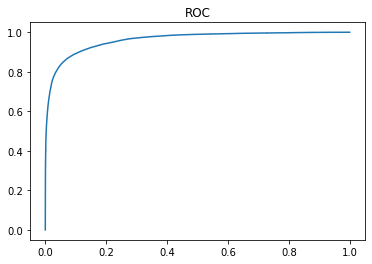

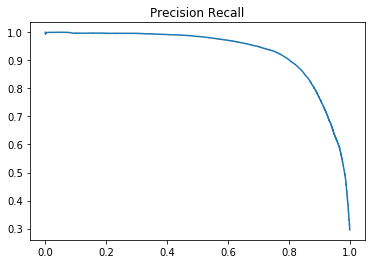

Best threshold according to corner rule and its index:  0.34207428     55468
Sensitivity:  0.8872268477735785
Specificity :  0.906732722226972
ON  A PARTICULAR THRESHOLD
This threshold being  0.34
Best threshold based on point closest to t: 0.3399978
Sensitivity at threshold : 0.88842601801597
Specificiy at threshold : 0.9051776128956228
Accuracy at threshold : 0.9003354569080796
CNN RMSE : 0.25033592159081536
------------------- TRAINING CNN --------------------------
Total points : 608722
Positive points : 175955
Negative points : 432767
AUC ROC: 0.9639050797284177
AUC PR:  0.9319519260187799


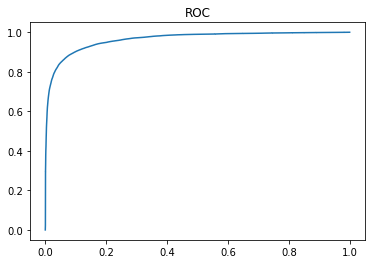

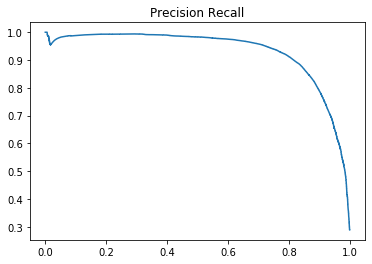

Best threshold according to corner rule and its index:  0.3107413     48483
Sensitivity:  0.8932681651558637
Specificity :  0.911079171933165
ON  A PARTICULAR THRESHOLD
This threshold being  0.31
Best threshold based on point closest to t: 0.30999818
Sensitivity at threshold : 0.8934386632945923
Specificiy at threshold : 0.910778779343157
Accuracy at threshold : 0.9057665075354595
LSTM RMSE : 0.2565693446922705
------------------- TRAINING LSTM --------------------------
Total points : 608722
Positive points : 175955
Negative points : 432767
AUC ROC: 0.9634277117563472
AUC PR:  0.9285851002439994


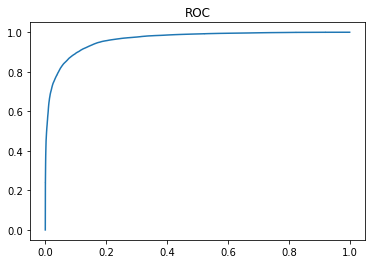

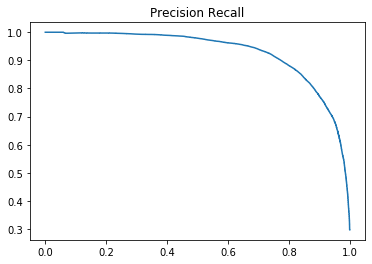

Best threshold according to corner rule and its index:  0.23285052     51283
Sensitivity:  0.8962461993123242
Specificity :  0.8975407089727266
ON  A PARTICULAR THRESHOLD
This threshold being  0.23
Best threshold based on point closest to t: 0.23000212
Sensitivity at threshold : 0.8978545650876645
Specificiy at threshold : 0.8957267998715244
Accuracy at threshold : 0.8963418440601786


In [14]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

y_true = mylabel

t = 0.34
print('SAX RMSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_prob_sax = mysax
getMetrics('TRAINING SAX',y_true,y_prob_sax,t)

t = 0.31
print('CNN RMSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('TRAINING CNN',y_true,y_prob_cnn,t)

t = 0.23
print('LSTM RMSE :', np.sqrt(TOTAL_ERROR_LSTM/TOTAL_PTS))
y_prob_lstm = mylstm
getMetrics('TRAINING LSTM',y_true,y_prob_lstm,t)


In [15]:
START = 110
END = 140
print('VALIDATION SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')

TOTAL_PTS = 0
TOTAL_ERROR_SAX = 0
TOTAL_ERROR_CNN = 0
TOTAL_ERROR_LSTM = 0

mylabel = []
mysax = []
mycnn = []
mylstm = []

cnn_model = getCNNModeltoInterpret('SegCNN.h5')
lstm_model = getLSTMModeltoInterpret('SegLSTM.h5')

for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(cnn_model, dfstat, data)
    LSTMpred = getLSTMSegMap(lstm_model, dfstat, data)
    
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    avgLSTMpred = movingAvg(LSTMpred,120)
    
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    mylstm = mylstm + list(avgLSTMpred)
    
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    error_lstm = sum(np.square(avgLSTMpred - y))
    
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_ERROR_LSTM += error_lstm
    
    TOTAL_PTS += TOTAL_LEN

VALIDATION SET
110 111 112 113 114 WARNING:tensorflow:5 out of the last 5 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcfdb36d4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
115 WARNING:tensorflow:6 out of the last 6 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcfdb36d4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that

128 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcfdb36d4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
129 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fcfdb36d4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retr

Total points : 160105
Positive points : 20520
Negative points : 139585
SAX RMSE : 0.2798702877652315
------------------- VALIDATION SAX --------------------------
Total points : 160105
Positive points : 20520
Negative points : 139585
AUC ROC: 0.8758101699545038
AUC PR:  0.6977575693472164


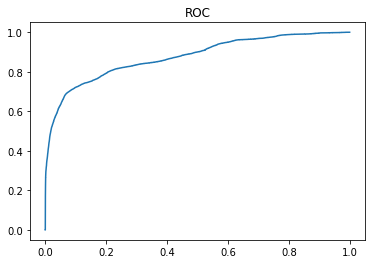

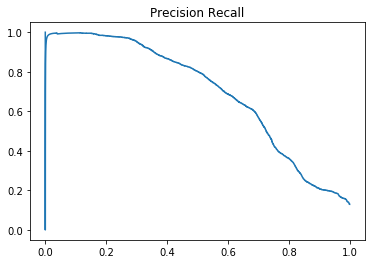

Best threshold according to corner rule and its index:  0.25484183     14467
Sensitivity:  0.7984892787524367
Specificity :  0.795135580470681
ON  A PARTICULAR THRESHOLD
This threshold being  0.34
Best threshold based on point closest to t: 0.33980238
Sensitivity at threshold : 0.7271929824561404
Specificiy at threshold : 0.8911272701221478
Accuracy at threshold : 0.8701164860560258
CNN RMSE : 0.2643161690646088
------------------- VALIDATION CNN --------------------------
Total points : 160105
Positive points : 20520
Negative points : 139585
AUC ROC: 0.8851279900926033
AUC PR:  0.692131132229615


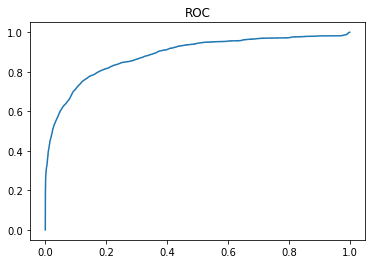

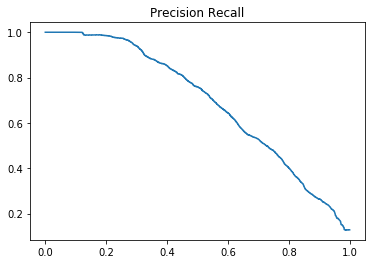

Best threshold according to corner rule and its index:  0.21478097     12911
Sensitivity:  0.7976608187134503
Specificity :  0.8284199591646667
ON  A PARTICULAR THRESHOLD
This threshold being  0.31
Best threshold based on point closest to t: 0.30997238
Sensitivity at threshold : 0.731140350877193
Specificiy at threshold : 0.8907045886019271
Accuracy at threshold : 0.8702538958808282
LSTM RMSE : 0.268980903136877
------------------- VALIDATION LSTM --------------------------
Total points : 160105
Positive points : 20520
Negative points : 139585
AUC ROC: 0.8903410813773296
AUC PR:  0.66417570851559


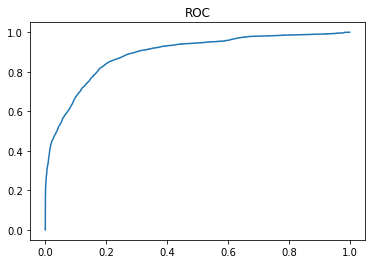

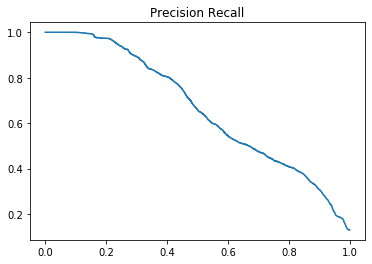

Best threshold according to corner rule and its index:  0.1511396     15538
Sensitivity:  0.8387914230019493
Specificity :  0.8021707203496078
ON  A PARTICULAR THRESHOLD
This threshold being  0.23
Best threshold based on point closest to t: 0.22999759
Sensitivity at threshold : 0.7311890838206627
Specificiy at threshold : 0.8692839488483719
Accuracy at threshold : 0.8515848974110738


In [16]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

y_true = mylabel

t = 0.34
print('SAX RMSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_prob_sax = mysax
getMetrics('VALIDATION SAX',y_true,y_prob_sax,t)

t = 0.31
print('CNN RMSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('VALIDATION CNN',y_true,y_prob_cnn,t)

t = 0.23
print('LSTM RMSE :', np.sqrt(TOTAL_ERROR_LSTM/TOTAL_PTS))
y_prob_lstm = mylstm
getMetrics('VALIDATION LSTM',y_true,y_prob_lstm,t)


In [17]:
START = 140
END = 180
print('TEST SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')

TOTAL_PTS = 0
TOTAL_ERROR_SAX = 0
TOTAL_ERROR_CNN = 0
TOTAL_ERROR_LSTM = 0

mylabel = []
mysax = []
mycnn = []
mylstm = []

cnn_model = getCNNModeltoInterpret('SegCNN.h5')
lstm_model = getLSTMModeltoInterpret('SegLSTM.h5')

for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(cnn_model, dfstat, data)
    LSTMpred = getLSTMSegMap(lstm_model, dfstat, data)
    
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    avgLSTMpred = movingAvg(LSTMpred,120)
    
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    mylstm = mylstm + list(avgLSTMpred)
    
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    error_lstm = sum(np.square(avgLSTMpred - y))
    
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_ERROR_LSTM += error_lstm
    
    TOTAL_PTS += TOTAL_LEN

TEST SET
140 141 142 143 144 WARNING:tensorflow:5 out of the last 5 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
145 WARNING:tensorflow:6 out of the last 6 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can a

158 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
159 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retr

172 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/beta/tutorials/eager/tf_function#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.
173 WARNING:tensorflow:11 out of the last 11 calls to <function _make_execution_function.<locals>.distributed_function at 0x7fd05144b290> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retr

Total points : 232232
Positive points : 64718
Negative points : 167514
SAX RMSE : 0.3052445798521349
------------------- TEST SAX --------------------------
Total points : 232232
Positive points : 64718
Negative points : 167514
AUC ROC: 0.9466834494421739
AUC PR:  0.8952023144641862


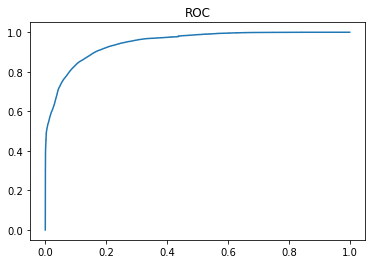

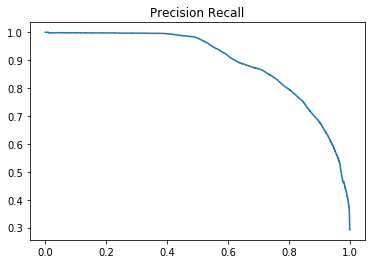

Best threshold according to corner rule and its index:  0.35007435     25991
Sensitivity:  0.867702957446151
Specificity :  0.8700825005671168
ON  A PARTICULAR THRESHOLD
This threshold being  0.34
Best threshold based on point closest to t: 0.3399927
Sensitivity at threshold : 0.8770821100775673
Specificiy at threshold : 0.8601728810726268
Accuracy at threshold : 0.8648851148851149
CNN RMSE : 0.2875860389577863
------------------- TEST CNN --------------------------
Total points : 232232
Positive points : 64718
Negative points : 167514
AUC ROC: 0.945550980408975
AUC PR:  0.8897484222251326


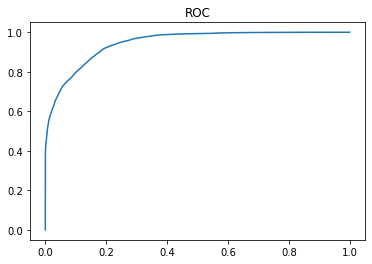

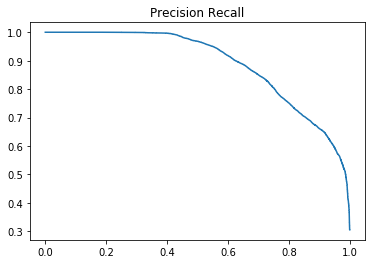

Best threshold according to corner rule and its index:  0.26638857     26660
Sensitivity:  0.8713031923112581
Specificity :  0.8473321632818749
ON  A PARTICULAR THRESHOLD
This threshold being  0.31
Best threshold based on point closest to t: 0.30999243
Sensitivity at threshold : 0.831561543929046
Specificiy at threshold : 0.8753477321298518
Accuracy at threshold : 0.8631454752144407
LSTM RMSE : 0.30072973353004406
------------------- TEST LSTM --------------------------
Total points : 232232
Positive points : 64718
Negative points : 167514
AUC ROC: 0.938515504524114
AUC PR:  0.8732842509348089


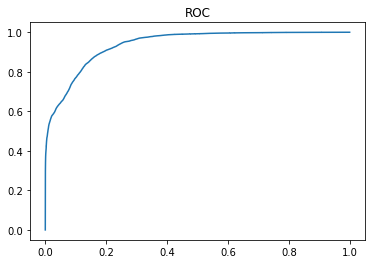

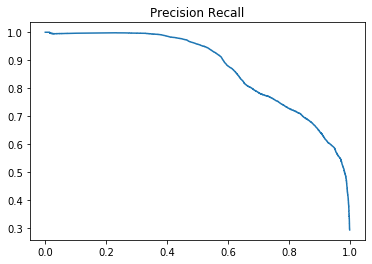

Best threshold according to corner rule and its index:  0.20013925     26390
Sensitivity:  0.8739145214623443
Specificity :  0.8403297634824551
ON  A PARTICULAR THRESHOLD
This threshold being  0.23
Best threshold based on point closest to t: 0.22999448
Sensitivity at threshold : 0.8388701752217312
Specificiy at threshold : 0.8663037119285553
Accuracy at threshold : 0.8586585827965139


In [19]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

y_true = mylabel

t = 0.34
print('SAX RMSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_prob_sax = mysax
getMetrics('TEST SAX',y_true,y_prob_sax,t)

t = 0.31
print('CNN RMSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('TEST CNN',y_true,y_prob_cnn,t)

t = 0.23
print('LSTM RMSE :', np.sqrt(TOTAL_ERROR_LSTM/TOTAL_PTS))
y_prob_lstm = mylstm
getMetrics('TEST LSTM',y_true,y_prob_lstm,t)

